### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

from sklearn.preprocessing import OneHotEncoder, StandardScaler

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

VERBOSE = 0
CV = 2
TESTING = False

ITER = 2

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-04-15 18:00:15.445677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 18:00:16.592726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
hyperparameterspace = {
    'loss': ["list", 'mean_absolute_error', 'mean_squared_error'],
    'epochs': ["interval-int", 1, 40],
    'batch_size': ["interval-int", 40, 160],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.001]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [3]:
ids = [233214, 233211, 359935, 359952, 359940, 359931]#, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

valid_datasets = 0
for i in range(len(ids)):
    task = tasks.get_task(ids[i])

    # Get dataset by ID
    dataset = task.get_dataset()

    print("Current dataset:", i, "of", len(ids), "with name:", dataset.name)

    # Get the data itself as a dataframe (or otherwise)
    data, target, categorical_indicator, names = dataset.get_data(dataset.default_target_attribute, dataset_format="array")

    # split into categorical and numerical features
    categorical_features = [[x[i] for i in range(len(x)) if categorical_indicator[i]] for x in data]
    numerical_features = [[x[i] for i in range(len(x)) if not categorical_indicator[i]] for x in data]
    
    if any(categorical_indicator):
        # one hot encoding of the categorical one
        encoder = OneHotEncoder(sparse_output=False).fit(categorical_features)
        transformed = encoder.transform(categorical_features)

        # bring back together
        data = [numerical_features[i] + transformed[i].tolist() for i in range(len(numerical_features))]
    else:
        data = numerical_features


    # additional scaling 
    scaler = StandardScaler().fit(data)
    data = scaler.transform(data)

    scaler = StandardScaler().fit(target.reshape(-1,1))
    target = scaler.transform(target.reshape(-1,1))

    X = torch.Tensor(data)
    Y = torch.Tensor(target)

    dataset = HPO.Dataset(X, Y)

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(): 
        # create model
        model = Sequential()
        model.add(Dense(20, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
        model.add(Dense(20, activation=ACTIVATION_FUNCTION))
        model.add(Dense(1, activation=None))
        return model


    def blackboxfunction(params):
        index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = hyperparameterspace_special["loss"][index]
        
        epochs = int(params[1])

        batch_size = int(params[2])

        model_learning_rate = params[3]

        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(20, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
            model.add(Dense(20, activation=ACTIVATION_FUNCTION))
            model.add(Dense(1, activation=None))
            # Compile model
            
            optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

            model.compile(loss=loss, optimizer=optimizer)
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

        if TESTING:
            print("Test set is being used")
            Y_predicted = model.predict(dataset.get_X_test())
            # if np.any(np.isnan(Y_predicted)):
            #     return -1000
            return -sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            #if np.any(np.isnan(Y_predicted)):
            #    return -1000
            return -sklearn.metrics.mean_squared_error(dataset.get_Y_validation(), Y_predicted)
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = hyperparameterspace_special["loss"][index]
            
            epochs = int(from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[1]))

            batch_size = int(from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[2]))

            model_learning_rate = from_standard(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[3])
            
            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(20, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
                model.add(Dense(20, activation=ACTIVATION_FUNCTION))
                model.add(Dense(1, activation=None))
                # Compile model
                
                optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

                model.compile(loss=loss, optimizer=optimizer,)
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                # if np.any(np.isnan(Y_predicted)):
                #     return 1000
                return sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                # if np.any(np.isnan(Y_predicted)):
                #     return 1000
                return sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
            


    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = 15 + j * 30      
                

        ############################## GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()
        
        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for i in range(len(result[1])):
            if result[1][i] == max(result[1]):
                index_best = i

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        TESTING = True
        BAYESIAN_RESULT.append(-blackboxfunction(best_params))
        TESTING = False

        BAYESIAN_COST.append(BUDGET)


        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="gradient_descent")

        result = optimization.fit()

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        TESTING = False

        SPARSE_COST.append(BUDGET)
        SPARSE_COST_OPTIMIZED.append(BUDGET)

    valid_datasets += 1
    



Current dataset: 0 of 6 with name: Santander_transaction_value
Performing grid search


2023-04-15 18:00:29.287047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 18:00:29.287973: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 85.2061924340087 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 89195ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization
Iterations took 218.95468523097225 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 92093ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 1ms.
Current dataset: 1 of 6 with name: diamonds
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 151.45045418606605 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 376608ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization
Iterations took 603.7927019440976 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 378246ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 2 of 6 with name: wine_quality
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization
Iterations took 66.12261761599802 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 65599ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization
Iterations took 199.25792636716506 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 65592ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 3 of 6 with name: house_16H
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization
Iterations took 105.10986560105812 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 160538ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization
Iterations took 290.4408499299607 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 161103ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 4 of 6 with name: yprop_4_1
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization
Iterations took 42.79676232900238 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 89190ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 92.42272196593694 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 90138ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 5 of 6 with name: sensory
Performing grid search
Performing random search


/home/maxi/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 19.269234522944316 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 26903ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 154.73055902603664 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 26124ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.


[0.9460407, 0.9276328, 0.027393503, 0.029131053, 0.6724503, 0.6477158, 0.48256916, 0.40302968, 0.9380609, 0.88789177, 0.85637236, 0.9273974]
[1.137772, 1.0619969, 0.046410352, 0.035859857, 0.6732134, 0.62899995, 0.50226194, 0.43062612, 0.9408365, 0.90072334, 0.9646627, 0.93599004]
[1.3460258, 1.6817906, 0.058638163, 0.046884317, 0.66619354, 0.64026517, 0.39250544, 0.4804328, 0.93397486, 0.958739, 0.95949477, 0.783462]
[0.9761453881870197, 1.1075185980335125, 0.03691153649745624, 0.05519454151805533, 0.65706959597586, 0.6622555274028868, 0.5046087818054853, 0.4867920915761172, 0.9907001037074413, 0.9237419289338789, 0.9434692062275964, 1.055329986616671]
[5.358262047244193, 1.2037269595691191, 0.0236844951929025, 0.027832675978292983, 0.6404994979188058, 0.6426793453988938, 0.5257115022025604, 0.5004971096333365, 0.9402773989609878, 0.9363771632464348, 0.8213203292098319, 1.0002566141805531]
Current dataset: 0 with name id: 233214


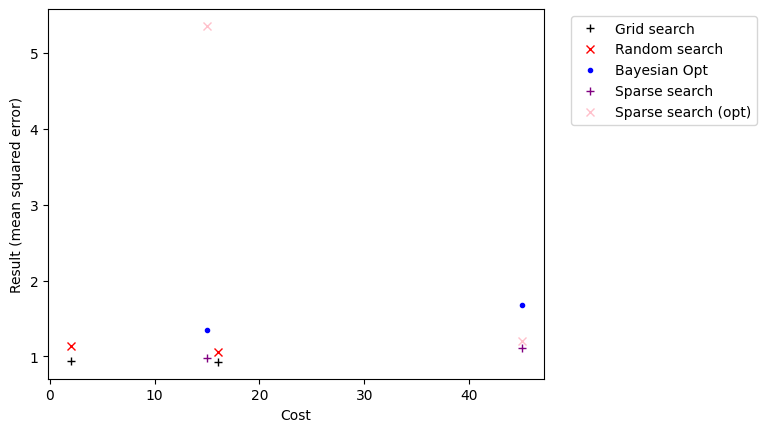

Current dataset: 1 with name id: 233211


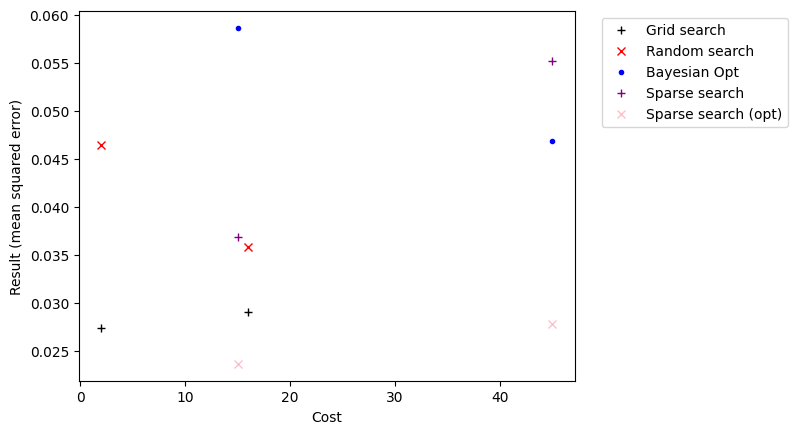

Current dataset: 2 with name id: 359935


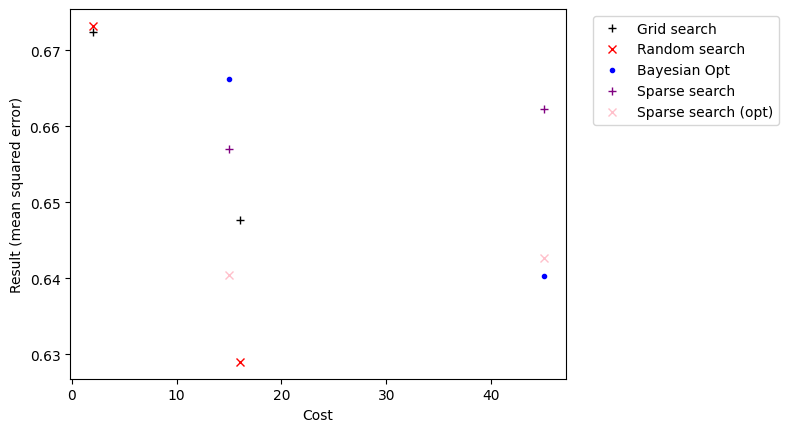

Current dataset: 3 with name id: 359952


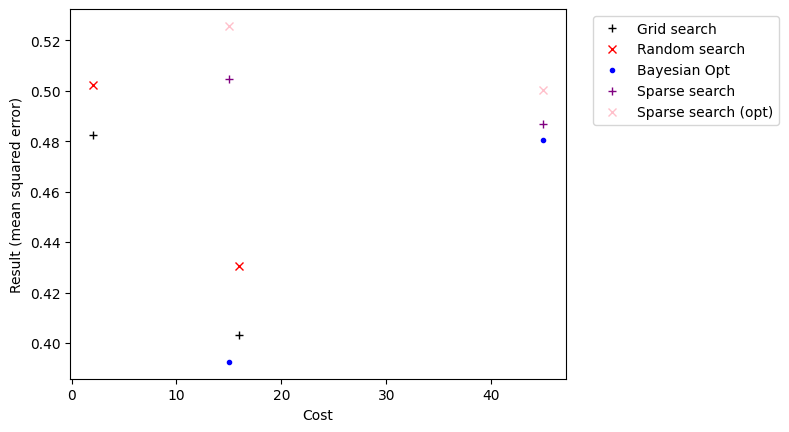

Current dataset: 4 with name id: 359940


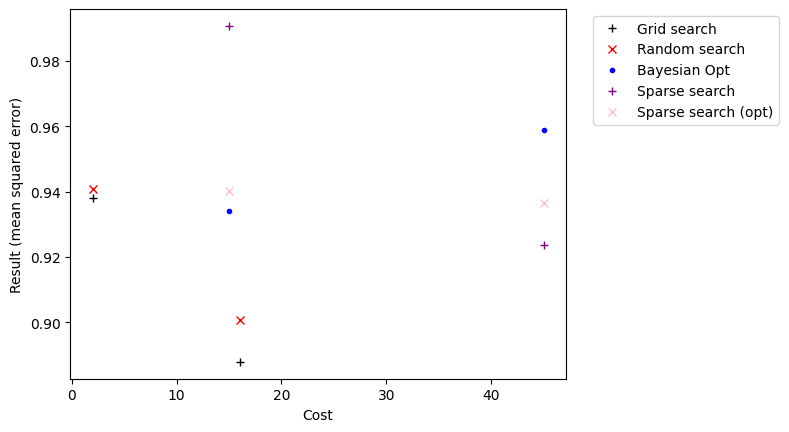

Current dataset: 5 with name id: 359931


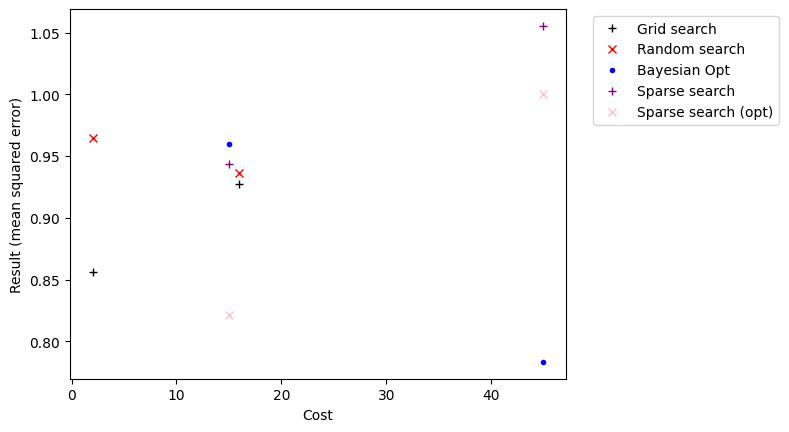

In [4]:
print(GRID_RESULT)
print(RANDOM_RESULT)
print(BAYESIAN_RESULT)
print(SPARSE_RESULT)
print(SPARSE_RESULT_OPTIMIZED)
count = 0
for i in range(valid_datasets):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        #plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

